In [3]:
from utils import *

mpl.rcParams.update(mpl.rcParamsDefault)

# sns.set_style("whitegrid")
# plt.style.use(['science', 'no-latex'])
# plt.rcParams['axes.unicode_minus']=False
plt.rcParams['savefig.dpi'] = 200 # 图片像素
plt.rcParams['figure.dpi'] = 200 # 分辨率

config = {
    "font.family":'serif',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
}
plt.rcParams.update(config)
%matplotlib inline


/data1/xiangyf/.conda/envs/py38/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/data1/xiangyf/.conda/envs/py38/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/data1/xiangyf/.conda/envs/py38/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Parameters

In [4]:
SAMPLE_DIR = './samples'

SINGLE_LEV_VARS = ['PRES_GDS3_SFC',  # Pressure
                   'HGT_GDS3_SFC', 'HGT_GDS3_0DEG', 'HGT_GDS3_HTFL', 'HGT_GDS3_CEIL', # Geopotential height, (lev_indicater不同)
                   'TMP_GDS3_SFC', 'TMP_GDS3_HTGL', 'WTMP_GDS3_SFC', # Temperature
                   'DPT_GDS3_HTGL', # Dew point temperature
                   'VIS_GDS3_SFC', # Visibility
                   'PLI_GDS3_SPDY', # Parcel lifted index (to 500 hPa) 反映一种潜在不稳定
                   'U_GRD_GDS3_HTGL', 'U_GRD_GDS3_SPDY', 'V_GRD_GDS3_HTGL', 'V_GRD_GDS3_SPDY', # Wind
                   'SPF_H_GDS3_HTGL', 'SPF_H_GDS3_HYBL', 'SPF_H_GDS3_SPDY', 'R_H_GDS3_HTGL', 'R_H_GDS3_HYBL', # Relative humidity
                   'P_WAT_GDS3_EATM', # Precipitable water
                   'POP_GDS3_SFC', # precipitation
                   'T_CDC_GDS3_EATM', 'L_CDC_GDS3_LCY', 'M_CDC_GDS3_MCY', 'H_CDC_GDS3_HCY', # Cloud
                   'SFC_R_GDS3_SFC', # Surface roughness
                   'MSLET_GDS3_MSL', # Mean sea level pressure
                   'LFT_X_GDS3_ISBY', # Surface lifted index
                   # 'CRAIN_GDS3_SFC', 'CFRZR_GDS3_SFC', # Categorical rain
                   'TCOLW_GDS3_EATM'] # Total column-integrated cloud water

TEMP_WTEMP = ['TEMP_WTEMP']
INFO_COLS  = ['time (t6)', 'year (t6)', 'month (t6)', 'hour (t6)',  
              'ori_ID (t6)', 'new_ID (t6)', 'lat (t6)', 'lon (t6)',
              'fsl_vis (t6)', 'VIS_GDS3_SFC (t6)', 'lead_hours']

TRAIN_YEARS = [2014, 2015, 2016, 2017, 2018]
VALID_YEARS = [2019]
TEST_YEARS  = [2020]

VIS_BEFORE_WRF_PRE_SEQ_LENGTH = 18
WRF_LENGTH = 6

LABEL     = 'visibility (t-0)'
CLS_LABEL = 'vis_cls (t-0)'

WRF_PRE_VIS = [f'vis_before_pre (t-{t})' for t in range(1, 7)]

WRF_COVAR = [f'{v} (t-{t})' for v in SINGLE_LEV_VARS if v!='VIS_GDS3_SFC' for t in range(WRF_LENGTH)]

RESULT_DIR = './forecast_results'

# Load Data

In [5]:
dataset_00 = get_dataset(SAMPLE_DIR, TRAIN_YEARS + VALID_YEARS + TEST_YEARS, '00', WRF_LENGTH, VIS_BEFORE_WRF_PRE_SEQ_LENGTH, stations='all')
dataset_00['spot_hour'] = 0
print(len(dataset_00))

dataset_12 = get_dataset(SAMPLE_DIR, TRAIN_YEARS + VALID_YEARS + TEST_YEARS, '12', WRF_LENGTH, VIS_BEFORE_WRF_PRE_SEQ_LENGTH, stations='all')
dataset_12['spot_hour'] = 12
print(len(dataset_12))

dataset = pd.concat([dataset_00, dataset_12], axis=0)
print(len(dataset))

del dataset_00
del dataset_12

# get the temperature difference between air and surface(sea)
# get the wind speed and angle
for t in range(7):
    dataset[f'TEMP_WTEMP (t{t})'] = dataset[f'TMP_GDS3_HTGL (t{t})'] - dataset[f'WTMP_GDS3_SFC (t{t})']
    
    u_wind = dataset[f'U_GRD_GDS3_HTGL (t{t})']
    v_wind = dataset[f'V_GRD_GDS3_HTGL (t{t})']
    wind_speed = np.sqrt(u_wind**2 + v_wind**2)
    wind_angle = np.arctan2(-u_wind, -v_wind) * 180 / np.pi
    dataset[f'wind_speed (t{t})'] = wind_speed
    dataset[f'wind_angle (t{t})'] = wind_angle

Selecting stations: all
Loading from ./samples/2014_spot00_wrf6_prev18_samples.csv
Loading from ./samples/2015_spot00_wrf6_prev18_samples.csv
Loading from ./samples/2016_spot00_wrf6_prev18_samples.csv
Loading from ./samples/2017_spot00_wrf6_prev18_samples.csv
Loading from ./samples/2018_spot00_wrf6_prev18_samples.csv
Loading from ./samples/2019_spot00_wrf6_prev18_samples.csv
Loading from ./samples/2020_spot00_wrf6_prev18_samples.csv
307409
Selecting stations: all
Loading from ./samples/2014_spot12_wrf6_prev18_samples.csv
Loading from ./samples/2015_spot12_wrf6_prev18_samples.csv
Loading from ./samples/2016_spot12_wrf6_prev18_samples.csv
Loading from ./samples/2017_spot12_wrf6_prev18_samples.csv
Loading from ./samples/2018_spot12_wrf6_prev18_samples.csv
Loading from ./samples/2019_spot12_wrf6_prev18_samples.csv
Loading from ./samples/2020_spot12_wrf6_prev18_samples.csv
300802
608211


# For missing observation data, fill with neareast value

In [6]:
for t in range(1, 18):
    col_candidate = f'vis_before_pre (t-{t})'
    col = f'vis_before_pre (t-{t+1})'
    print(col, col_candidate)
    
    dataset[col] = dataset[col].fillna(value=dataset[col_candidate])

vis_before_pre (t-2) vis_before_pre (t-1)
vis_before_pre (t-3) vis_before_pre (t-2)
vis_before_pre (t-4) vis_before_pre (t-3)
vis_before_pre (t-5) vis_before_pre (t-4)
vis_before_pre (t-6) vis_before_pre (t-5)
vis_before_pre (t-7) vis_before_pre (t-6)
vis_before_pre (t-8) vis_before_pre (t-7)
vis_before_pre (t-9) vis_before_pre (t-8)
vis_before_pre (t-10) vis_before_pre (t-9)
vis_before_pre (t-11) vis_before_pre (t-10)
vis_before_pre (t-12) vis_before_pre (t-11)
vis_before_pre (t-13) vis_before_pre (t-12)
vis_before_pre (t-14) vis_before_pre (t-13)
vis_before_pre (t-15) vis_before_pre (t-14)
vis_before_pre (t-16) vis_before_pre (t-15)
vis_before_pre (t-17) vis_before_pre (t-16)
vis_before_pre (t-18) vis_before_pre (t-17)


In [7]:
dataset.dropna(subset=WRF_PRE_VIS, how='all', inplace=True)

# Get visibility via NOAA's FSL algorithm

In [8]:
dataset['TMP_DPT (t6)'] = dataset['TMP_GDS3_HTGL (t6)'] - dataset['DPT_GDS3_HTGL (t6)']
fsl_vis, fsl_var = calc_vis_via_fsl(dataset)
print(fsl_vis.shape, len(dataset), fsl_var)
dataset['fsl_vis (t6)'] = fsl_vis
dataset['fsl_vis (t6)']

(479368, 1) 479368 ['fsl_vis (t6)']


2257     0.741191
2312     8.614315
5285     2.101841
9160    25.636947
9208    14.018941
          ...    
5799     3.891747
5805    10.767582
5829    17.352768
5851     8.973908
7395    30.000000
Name: fsl_vis (t6), Length: 479368, dtype: float64

# Set label for classification

In [9]:
dataset[CLS_LABEL] = np.where((dataset['visibility (t6)']<=1) & 
                              (dataset['current_weather (t6)']>=40) & 
                              (dataset['current_weather (t6)']<=49), 1, 0) 
fog_num = len(np.where(dataset[CLS_LABEL]==1)[0].tolist())
no_fog_num = len(np.where(dataset[CLS_LABEL]==0)[0].tolist())
print(no_fog_num, fog_num)

471066 8302


# Imbalance Data

Fog/Fog-free= 0.05715910706668562


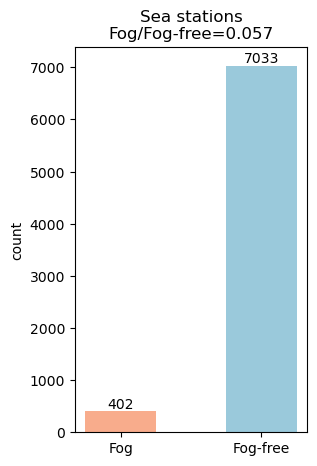

In [10]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

land_samples = dataset[dataset['ori_ID (t6)']!=99999]
sea_samples = dataset[dataset['ori_ID (t6)']==99999]

fog_in_land_samples = land_samples[land_samples[CLS_LABEL] == 1]
nofog_in_land_samples = land_samples[land_samples[CLS_LABEL] == 0]

fog_in_sea_samples = sea_samples[sea_samples[CLS_LABEL] == 1]
nofog_in_sea_samples = sea_samples[sea_samples[CLS_LABEL] == 0]


fog_num = len(fog_in_sea_samples)
no_fog_num = len(nofog_in_sea_samples)

x = ["Fog", "Fog-free"]
y = [fog_num, no_fog_num]
print('Fog/Fog-free=', fog_num/no_fog_num)

fig, ax = plt.subplots(dpi=100, figsize=(3, 5)) 
rects = ax.bar(x, y, 
               width=0.5, 
               color=['#F8AC8C', '#9AC9DB'])

ax.set_title(f"Sea stations\nFog/Fog-free={round(fog_num/no_fog_num, 3)}")
# ax.set_xlabel("Weather", fontsize=16)
ax.set_ylabel("count")

for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
#                 fontsize=12
               )
    
# plt.yticks(fontproperties='Times New Roman')
# plt.xticks(fontproperties='Times New Roman')

plt.show()

# Split train, valid and test data

In [11]:
train_dataset = dataset[dataset['year (t6)'] <= 2017]
train_dataset.drop_duplicates(inplace=True)
train_dataset.reset_index(drop=True, inplace=True)
print('train_dataset: ', len(train_dataset))

valid_dataset = dataset[dataset['year (t6)'] == 2018]
valid_dataset.drop_duplicates(inplace=True)
valid_dataset.reset_index(drop=True, inplace=True)
print('valid_dataset: ', len(valid_dataset))

test_dataset = dataset[dataset['year (t6)'] >= 2019]
test_dataset.drop_duplicates(inplace=True)
test_dataset.reset_index(drop=True, inplace=True)
print('test_dataset: ', len(test_dataset))

<ipython-input-11-4bd59f015f4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset.drop_duplicates(inplace=True)


train_dataset:  320843


<ipython-input-11-4bd59f015f4a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_dataset.drop_duplicates(inplace=True)


valid_dataset:  79595
test_dataset:  78930


<ipython-input-11-4bd59f015f4a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset.drop_duplicates(inplace=True)


# Features Selection

## Use all variables without time lag

In [36]:
lgb_file_1        = os.path.join(RESULT_DIR, 'model', 'lgb_use_all_var_without_time_lag.txt')
pre_result_file_1 = os.path.join(RESULT_DIR, 'test_result_use_all_var_without_time_lag.csv')
pre_metric_file_1 = os.path.join(RESULT_DIR, 'metrics_use_all_var_without_time_lag.csv')

In [37]:
features_1 = [f'{v} (t6)' for v in SINGLE_LEV_VARS]
features_1 += [f'vis_before_pre (t-{t})' for t in range(1, 7)]
features_1 += ['TEMP_WTEMP (t6)', 'wind_speed (t6)']
features_1 += ['lat (t6)', 'lon (t6)', 'hour (t6)', 'day (t6)', 'month (t6)', 'lead_hours']
print(len(features_1))
features_1

44


['PRES_GDS3_SFC (t6)',
 'HGT_GDS3_SFC (t6)',
 'HGT_GDS3_0DEG (t6)',
 'HGT_GDS3_HTFL (t6)',
 'HGT_GDS3_CEIL (t6)',
 'TMP_GDS3_SFC (t6)',
 'TMP_GDS3_HTGL (t6)',
 'WTMP_GDS3_SFC (t6)',
 'DPT_GDS3_HTGL (t6)',
 'VIS_GDS3_SFC (t6)',
 'PLI_GDS3_SPDY (t6)',
 'U_GRD_GDS3_HTGL (t6)',
 'U_GRD_GDS3_SPDY (t6)',
 'V_GRD_GDS3_HTGL (t6)',
 'V_GRD_GDS3_SPDY (t6)',
 'SPF_H_GDS3_HTGL (t6)',
 'SPF_H_GDS3_HYBL (t6)',
 'SPF_H_GDS3_SPDY (t6)',
 'R_H_GDS3_HTGL (t6)',
 'R_H_GDS3_HYBL (t6)',
 'P_WAT_GDS3_EATM (t6)',
 'POP_GDS3_SFC (t6)',
 'T_CDC_GDS3_EATM (t6)',
 'L_CDC_GDS3_LCY (t6)',
 'M_CDC_GDS3_MCY (t6)',
 'H_CDC_GDS3_HCY (t6)',
 'SFC_R_GDS3_SFC (t6)',
 'MSLET_GDS3_MSL (t6)',
 'LFT_X_GDS3_ISBY (t6)',
 'TCOLW_GDS3_EATM (t6)',
 'vis_before_pre (t-1)',
 'vis_before_pre (t-2)',
 'vis_before_pre (t-3)',
 'vis_before_pre (t-4)',
 'vis_before_pre (t-5)',
 'vis_before_pre (t-6)',
 'TEMP_WTEMP (t6)',
 'wind_speed (t6)',
 'lat (t6)',
 'lon (t6)',
 'hour (t6)',
 'day (t6)',
 'month (t6)',
 'lead_hours']

### Train

In [38]:
X_train = train_dataset[features_1]
y_train = train_dataset[CLS_LABEL]

X_valid = valid_dataset[features_1]
y_valid = valid_dataset[CLS_LABEL]

X_test = test_dataset[features_1]
y_test = test_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 6,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, focal_loss = create_lgb(X_train, y_train, 
                               X_valid, y_valid, 
                               features = features_1, 
                               model_params = model_params, 
                               use_focal_loss = False)

print(f'\nSaving model to {lgb_file_1}')
model.save_model(lgb_file_1)


Strating train...
Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's binary_logloss: 0.0620499
[600]	valid_0's binary_logloss: 0.0604818
[900]	valid_0's binary_logloss: 0.0608929
Early stopping, best iteration is:
[630]	valid_0's binary_logloss: 0.060441
Train Finished

Saving model to ./forecast_results/model/lgb_use_all_var_without_time_lag.txt


### Test

In [39]:
print(f'Loading model from {lgb_file_1}\n')
clf = lgb.Booster(model_file = lgb_file_1)

# predict probabilities
pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = (pre_probs + (-np.min(pre_probs))) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_1}')
pre_result_df.to_csv(pre_result_file_1)

# pre_result_df[pre_result_df['gt']==1]

Loading model from ./forecast_results/model/lgb_use_all_var_without_time_lag.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_use_all_var_without_time_lag.csv


Loading results from ./forecast_results/test_result_use_all_var_without_time_lag.csv

PR AUC=0.192


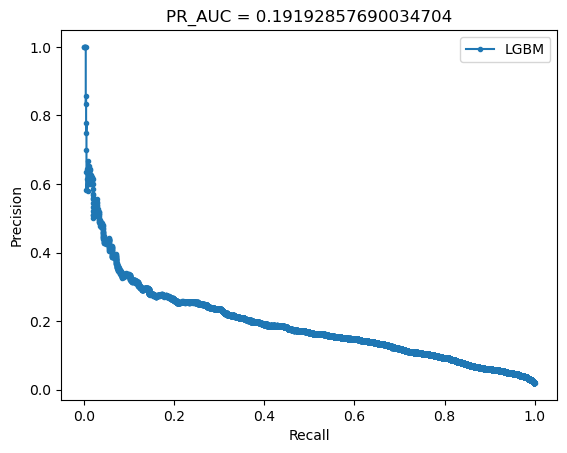

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


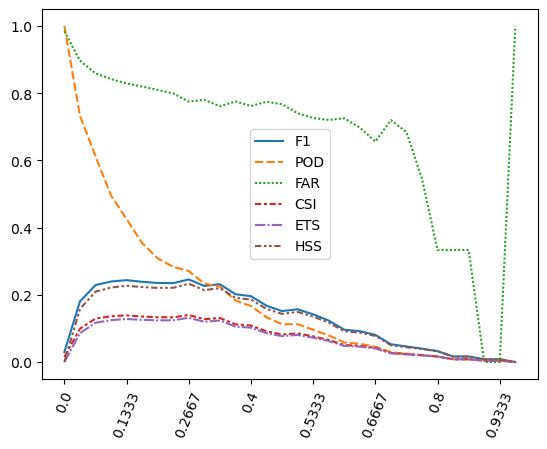


----------------------Max ETS------------------------
      thres        F1       POD       FAR       CSI       ETS       HSS
8  0.266667  0.245747  0.270833  0.775087  0.140086  0.131866  0.233006


In [40]:
print(f'Loading results from {pre_result_file_1}\n')
pre_result_df = pd.read_csv(pre_result_file_1, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

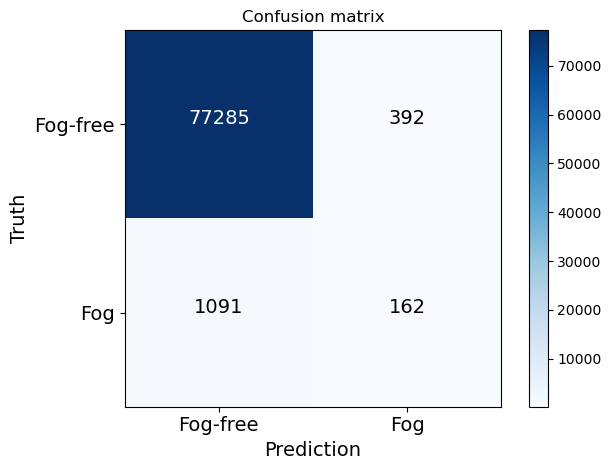

F1:0.179, POD:0.129, FAR:0.708, ETS:0.094, HSS:0.17


In [41]:
thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## Use all variables with time lag

In [42]:
lgb_file_2        = os.path.join(RESULT_DIR, 'model', 'lgb_use_all_var_with_time_lag.txt')
pre_result_file_2 = os.path.join(RESULT_DIR, 'test_result_use_all_var_with_time_lag.csv')
pre_metric_file_2 = os.path.join(RESULT_DIR, 'metrics_use_all_var_with_time_lag.csv')

In [43]:
features_2 = [f'{v} (t{t})' for v in SINGLE_LEV_VARS for t in range(0, 7)]
features_2 += [f'vis_before_pre (t-{t})' for t in range(1, 7)]
features_2 += [f'TEMP_WTEMP (t{t})' for t in range(0, 7)]
features_2 += ['lat (t6)', 'lon (t6)', 'hour (t6)', 'day (t6)', 'month (t6)', 'lead_hours', 'wind_speed (t6)']
print(len(features_2))
features_2

230


['PRES_GDS3_SFC (t0)',
 'PRES_GDS3_SFC (t1)',
 'PRES_GDS3_SFC (t2)',
 'PRES_GDS3_SFC (t3)',
 'PRES_GDS3_SFC (t4)',
 'PRES_GDS3_SFC (t5)',
 'PRES_GDS3_SFC (t6)',
 'HGT_GDS3_SFC (t0)',
 'HGT_GDS3_SFC (t1)',
 'HGT_GDS3_SFC (t2)',
 'HGT_GDS3_SFC (t3)',
 'HGT_GDS3_SFC (t4)',
 'HGT_GDS3_SFC (t5)',
 'HGT_GDS3_SFC (t6)',
 'HGT_GDS3_0DEG (t0)',
 'HGT_GDS3_0DEG (t1)',
 'HGT_GDS3_0DEG (t2)',
 'HGT_GDS3_0DEG (t3)',
 'HGT_GDS3_0DEG (t4)',
 'HGT_GDS3_0DEG (t5)',
 'HGT_GDS3_0DEG (t6)',
 'HGT_GDS3_HTFL (t0)',
 'HGT_GDS3_HTFL (t1)',
 'HGT_GDS3_HTFL (t2)',
 'HGT_GDS3_HTFL (t3)',
 'HGT_GDS3_HTFL (t4)',
 'HGT_GDS3_HTFL (t5)',
 'HGT_GDS3_HTFL (t6)',
 'HGT_GDS3_CEIL (t0)',
 'HGT_GDS3_CEIL (t1)',
 'HGT_GDS3_CEIL (t2)',
 'HGT_GDS3_CEIL (t3)',
 'HGT_GDS3_CEIL (t4)',
 'HGT_GDS3_CEIL (t5)',
 'HGT_GDS3_CEIL (t6)',
 'TMP_GDS3_SFC (t0)',
 'TMP_GDS3_SFC (t1)',
 'TMP_GDS3_SFC (t2)',
 'TMP_GDS3_SFC (t3)',
 'TMP_GDS3_SFC (t4)',
 'TMP_GDS3_SFC (t5)',
 'TMP_GDS3_SFC (t6)',
 'TMP_GDS3_HTGL (t0)',
 'TMP_GDS3_HTGL (t1)',
 '

### Train

In [44]:
X_train = train_dataset[features_2]
y_train = train_dataset[CLS_LABEL]

X_valid = valid_dataset[features_2]
y_valid = valid_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 6,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, focal_loss = create_lgb(X_train, y_train, 
                               X_valid, y_valid, 
                               features = features_2, 
                               model_params = model_params, 
                               use_focal_loss = False)

print(f'\nSaving model to {lgb_file_2}')
model.save_model(lgb_file_2)


Strating train...
Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's binary_logloss: 0.0612869
[600]	valid_0's binary_logloss: 0.0597019
[900]	valid_0's binary_logloss: 0.0597346
Early stopping, best iteration is:
[745]	valid_0's binary_logloss: 0.0596181
Train Finished

Saving model to ./forecast_results/model/lgb_use_all_var_with_time_lag.txt


### Test

In [45]:
print(f'Loading model from {lgb_file_2}\n')
clf = lgb.Booster(model_file = lgb_file_2)

X_test = test_dataset[features_2]
y_test = test_dataset[CLS_LABEL]

# predict probabilities
pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = (pre_probs + (-np.min(pre_probs))) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_2}')
pre_result_df.to_csv(pre_result_file_2)

Loading model from ./forecast_results/model/lgb_use_all_var_with_time_lag.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_use_all_var_with_time_lag.csv


Loading results from ./forecast_results/test_result_use_all_var_with_time_lag.csv

PR AUC=0.195


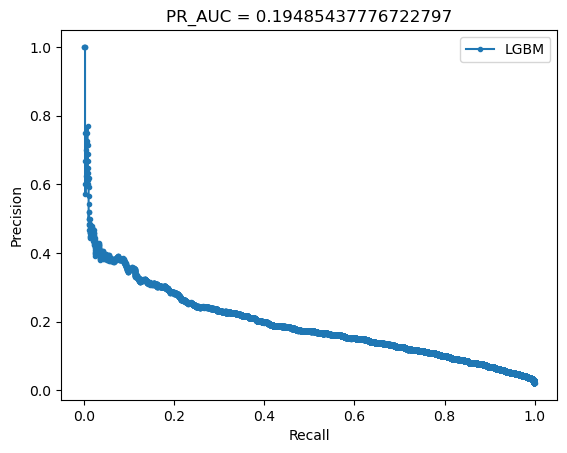

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


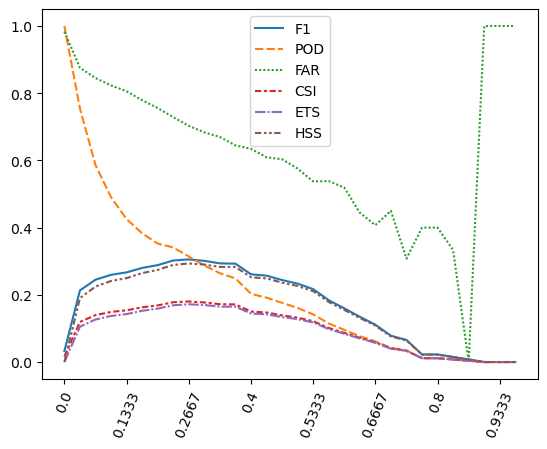


----------------------Max ETS------------------------
      thres      F1       POD       FAR      CSI       ETS       HSS
8  0.266667  0.3054  0.314176  0.702899  0.18022  0.171915  0.293391


In [46]:
print(f'Loading results from {pre_result_file_2}\n')
pre_result_df = pd.read_csv(pre_result_file_2, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

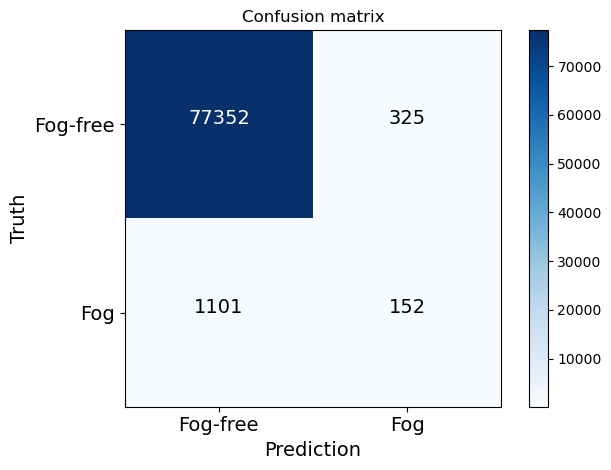

F1:0.176, POD:0.121, FAR:0.681, ETS:0.092, HSS:0.17


In [47]:
thres = 0.5
#  pre_result_df = pre_result_df[pre_result_df['ori_ID (t6)'] != 99999]

pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## Use variables from TLCA

In [48]:
lgb_file_3        = os.path.join(RESULT_DIR, 'model', 'lgb_use_var_from_TLCA.txt')
pre_result_file_3 = os.path.join(RESULT_DIR, 'test_result_use_var_from_TLCA.csv')
pre_metric_file_3 = os.path.join(RESULT_DIR, 'metrics_use_var_from_TLCA.csv')

In [54]:
fog_3_7_corr = pd.read_csv('./TLCA_results/fog_3_7_pearson_corr.csv', index_col=0)

fog_3_7_corr = fog_3_7_corr[fog_3_7_corr['sig'] < 0.05]
fog_3_7_corr['r'] = abs(fog_3_7_corr['r'])
fog_3_7_corr = fog_3_7_corr[1:].sort_values(by='r', ascending=False)
fog_3_7_corr

features_3 = fog_3_7_corr['variables'].tolist()
features_3 += [f'vis_before_pre (t-{t})' for t in range(1, 7)]
features_3 += ['lat (t6)', 'lon (t6)', 'hour (t6)', 'day (t6)', 'month (t6)', 'lead_hours']
print(len(features_3))
features_3

125


['R_H_GDS3_HYBL (t5)',
 'R_H_GDS3_HYBL (t6)',
 'R_H_GDS3_HYBL (t4)',
 'R_H_GDS3_HYBL (t3)',
 'R_H_GDS3_HYBL (t2)',
 'R_H_GDS3_HTGL (t5)',
 'R_H_GDS3_HTGL (t4)',
 'R_H_GDS3_HTGL (t6)',
 'R_H_GDS3_HYBL (t1)',
 'R_H_GDS3_HTGL (t3)',
 'R_H_GDS3_HTGL (t2)',
 'R_H_GDS3_HTGL (t1)',
 'R_H_GDS3_HYBL (t0)',
 'L_CDC_GDS3_LCY (t6)',
 'R_H_GDS3_HTGL (t0)',
 'L_CDC_GDS3_LCY (t5)',
 'HGT_GDS3_CEIL (t6)',
 'L_CDC_GDS3_LCY (t4)',
 'HGT_GDS3_CEIL (t4)',
 'HGT_GDS3_CEIL (t5)',
 'L_CDC_GDS3_LCY (t3)',
 'T_CDC_GDS3_EATM (t6)',
 'T_CDC_GDS3_EATM (t5)',
 'HGT_GDS3_CEIL (t2)',
 'T_CDC_GDS3_EATM (t4)',
 'L_CDC_GDS3_LCY (t2)',
 'HGT_GDS3_CEIL (t3)',
 'T_CDC_GDS3_EATM (t3)',
 'L_CDC_GDS3_LCY (t1)',
 'TEMP_WTEMP (t4)',
 'TEMP_WTEMP (t5)',
 'TEMP_WTEMP (t3)',
 'T_CDC_GDS3_EATM (t2)',
 'TEMP_WTEMP (t6)',
 'TEMP_WTEMP (t2)',
 'HGT_GDS3_CEIL (t1)',
 'WTMP_GDS3_SFC (t6)',
 'WTMP_GDS3_SFC (t5)',
 'TMP_GDS3_SFC (t6)',
 'TMP_GDS3_SFC (t5)',
 'WTMP_GDS3_SFC (t4)',
 'TMP_GDS3_SFC (t4)',
 'T_CDC_GDS3_EATM (t1)',
 'WTMP_GDS3

### Train

In [55]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

X_valid = valid_dataset[features_3]
y_valid = valid_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 6,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, focal_loss = create_lgb(X_train, y_train, 
                               X_valid, y_valid, 
                               features = features_3, 
                               model_params = model_params, 
                               use_focal_loss = False)

print(f'\nSaving model to {lgb_file_3}')
model.save_model(lgb_file_3)


Strating train...
Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's binary_logloss: 0.0616114
[600]	valid_0's binary_logloss: 0.0600948
[900]	valid_0's binary_logloss: 0.0597587
Early stopping, best iteration is:
[823]	valid_0's binary_logloss: 0.0597327
Train Finished


NameError: name 'lgb_file_3' is not defined

### Test

In [51]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

print(f'Loading model from {lgb_file_3}\n')
clf = lgb.Booster(model_file = lgb_file_3)

# predict probabilities
pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = (pre_probs - np.min(pre_probs)) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_3}')
pre_result_df.to_csv(pre_result_file_3)

# pre_result_df[pre_result_df['gt']==1]
# pre_result_df

Loading model from ./forecast_results/model/lgb_use_var_from_TLCA.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_use_var_from_TLCA.csv


Loading results from ./forecast_results/test_result_use_var_from_TLCA.csv

PR AUC=0.193


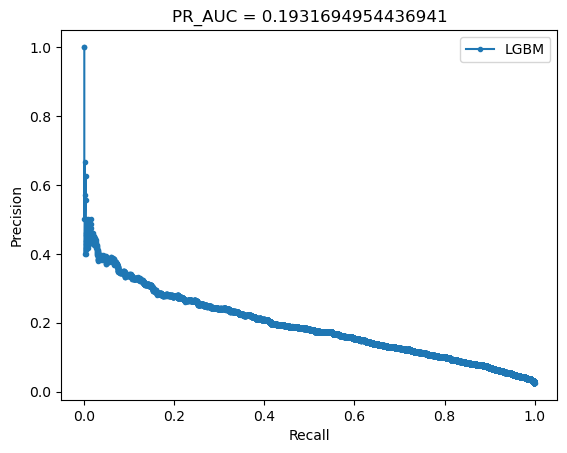

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


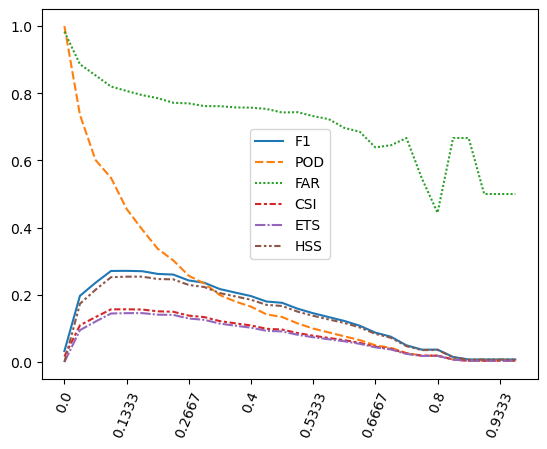


----------------------Max ETS------------------------
      thres        F1       POD       FAR       CSI       ETS       HSS
5  0.166667  0.270341  0.394636  0.794411  0.156297  0.145557  0.254125


In [52]:
print(f'Loading results from {pre_result_file_3}\n')
pre_result_df = pd.read_csv(pre_result_file_3, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

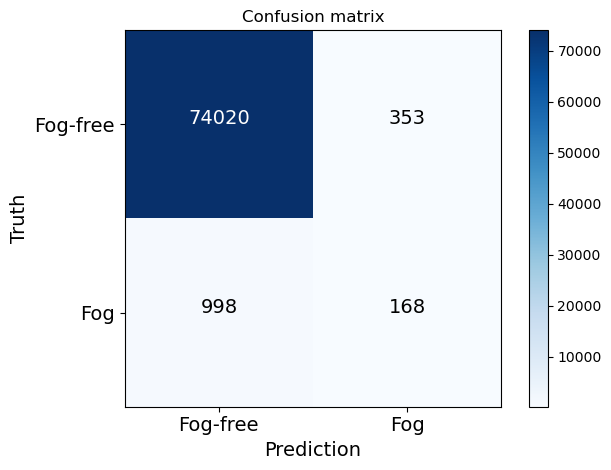

F1:0.199, POD:0.144, FAR:0.678, ETS:0.106, HSS:0.19


In [53]:
thres = 0.5
pre_result_df = pre_result_df[pre_result_df['ori_ID (t6)'] != 99999]

pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, 
                                                                         pre_result_df['gt'], 
                                                                         show_img=True)

print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## Compare

| Method  | F1  |  POD |  FAR | ETS | HSS |
|---|---|---|---|---| ---|
|  Use all variables without time lag  |  0.179  | 0.129  | 0.708  | 0.094  |  0.17 |
|  Use all variables with time lag  | 0.176  |  0.121 | 0.681  | 0.092  |  0.17 |
|  Use variables from TLCA  |  0.199 | 0.144  |  0.678 | 0.106  | 0.19  |

# Focal Loss

## alpha=0.2, gamma=2

In [56]:
lgb_file_4        = os.path.join(RESULT_DIR, 'model', 'lgb_use_var_from_TDCA_focal_loss_02_2.txt')
pre_result_file_4 = os.path.join(RESULT_DIR, 'test_result_use_var_from_TDCA_focal_loss_02_2.csv')

### Train

In [57]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 8,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, fl_obj = create_lgb(X_train, y_train, 
                           X_val, y_val, 
                           features = features_3, 
                           model_params = model_params,
                           use_focal_loss = True,
                           fl_alpha = 0.2, 
                           fl_gamma = 2)

print(f'\nSaving model to {lgb_file_4}')
model.save_model(lgb_file_4)


Strating train...

Use focal loss (alpha=0.2, gamma=2)....

Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.0089337
[600]	valid_0's focal_loss: 0.00526379
[900]	valid_0's focal_loss: 0.00507062
[1200]	valid_0's focal_loss: 0.00507172
Early stopping, best iteration is:
[1041]	valid_0's focal_loss: 0.00505938
Train Finished

Saving model to ./forecast_results/model/lgb_use_var_from_TDCA_focal_loss_02_2.txt


### Test

In [58]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

print(f'Loading model from {lgb_file_4}\n')
clf = lgb.Booster(model_file = lgb_file_4)

# predict probabilities
pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = (pre_probs + (-np.min(pre_probs))) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df['pred_probs'] = pre_result_df['pred_probs'] + (-np.min(pre_probs))
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_4}')
pre_result_df.to_csv(pre_result_file_4)

Loading model from ./forecast_results/model/lgb_use_var_from_TDCA_focal_loss_02_2.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_use_var_from_TDCA_focal_loss_02_2.csv


,pred_probs,gt,year (t6),month (t6),hour (t6),ori_ID (t6),new_ID (t6),lat (t6),lon (t6),fsl_vis (t6),VIS_GDS3_SFC (t6),lead_hours,fsl_vis_cls,wrf_vis_cls
count,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000
mean,0.206564,0.015875,2019.035943,5.982402,12.514253,60223.428785,176.952452,30.675314,121.802676,16.518279,13014.860158,32.905891,0.034246,0.071456
std,0.161042,0.124992,0.186150,3.247838,6.675434,8428.002307,217.995767,0.897186,0.486421,10.787685,7816.045785,16.632527,0.181860,0.257586
min,0.000000,0.000000,2019.000000,1.000000,2.000000,58265.000000,101.000000,28.100000,121.080000,0.000000,18.219985,6.000000,0.000000,0.000000
25%,0.079927,0.000000,2019.000000,3.000000,8.000000,58362.000000,111.000000,30.030000,121.450000,6.237177,9193.637678,18.000000,0.000000,0.000000
50%,0.164618,0.000000,2019.000000,6.000000,14.000000,58472.000000,142.000000,30.730000,121.950000,15.286546,11706.019710,33.000000,0.000000,0.000000
75%,0.290295,0.000000,2019.000000,8.000000,17.000000,58477.000000,143.000000,31.400000,122.100000,30.000000,15684.093671,48.000000,0.000000,0.000000
max,1.000000,1.000000,2020.000000,12.000000,23.000000,99999.000000,1953.000000,32.500000,125.200000,30.000000,60084.659555,60.000000,1.000000,1.000000


Loading results from ./forecast_results/test_result_use_var_from_TDCA_focal_loss_02_2.csv

PR AUC=0.197


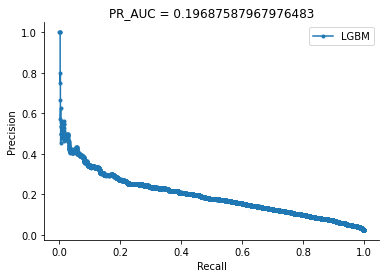

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


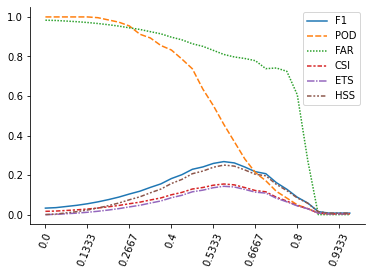


----------------------Max ETS------------------------
       thres        F1       POD       FAR       CSI       ETS       HSS
17  0.566667  0.268156  0.456274  0.810127  0.154839  0.143198  0.250522


In [59]:
print(f'Loading results from {pre_result_file_4}\n')
pre_result_df = pd.read_csv(pre_result_file_4, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

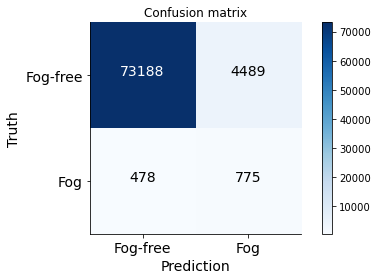

F1:0.238, POD:0.619, FAR:0.853, ETS:0.122, HSS:0.22


In [60]:
thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## alpha=0.2, gamma=4

In [62]:
fl_alpha = 0.2
fl_gamma = 4

lgb_file_5 = os.path.join(RESULT_DIR, 'model', 'lgb_use_var_from_TDCA_focal_loss_02_4.txt')
pre_result_file_5 = os.path.join(RESULT_DIR, 'test_result_use_var_from_TDCA_focal_loss_02_4.csv')
pre_metric_file_5 = os.path.join(RESULT_DIR, 'metrics_use_var_from_TDCA_focal_loss_02_4.csv')

### Train

In [63]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 8,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, fl_obj = create_lgb(X_train, y_train, 
                           X_val, y_val, 
                           features = features_3, 
                           model_params = model_params,
                           use_focal_loss = True,
                           fl_alpha = fl_alpha, 
                           fl_gamma = fl_gamma)

print(f'\nSaving model to {lgb_file_5}')
model.save_model(lgb_file_5)


Strating train...

Use focal loss (alpha=0.2, gamma=4)....

Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.0025025
[600]	valid_0's focal_loss: 0.0015733
[900]	valid_0's focal_loss: 0.00154036
Early stopping, best iteration is:
[820]	valid_0's focal_loss: 0.00153713
Train Finished

Saving model to ./forecast_results/model/lgb_use_var_from_TDCA_focal_loss_02_4.txt


### Test

In [64]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

print(f'Loading model from {lgb_file_5}\n')
clf = lgb.Booster(model_file = lgb_file_5)

# predict probabilities
pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = (pre_probs + (-np.min(pre_probs))) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df['pred_probs'] = pre_result_df['pred_probs'] + (-np.min(pre_probs))
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_5}')
pre_result_df.to_csv(pre_result_file_5)

Loading model from ./forecast_results/model/lgb_use_var_from_TDCA_focal_loss_02_4.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_use_var_from_TDCA_focal_loss_02_4.csv


Loading results from ./forecast_results/test_result_use_var_from_TDCA_focal_loss_02_4.csv

PR AUC=0.195


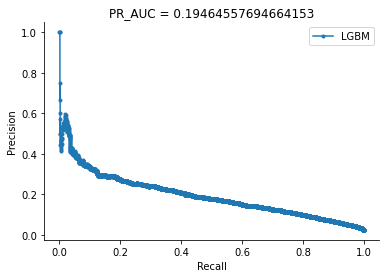

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


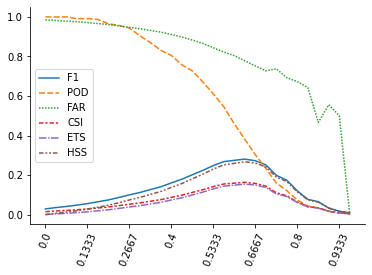


----------------------Max ETS------------------------
       thres        F1       POD       FAR       CSI       ETS       HSS
19  0.633333  0.280702  0.380952  0.777778  0.163265  0.154172  0.267156


In [65]:
print(f'Loading results from {pre_result_file_5}\n')
pre_result_df = pd.read_csv(pre_result_file_5, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

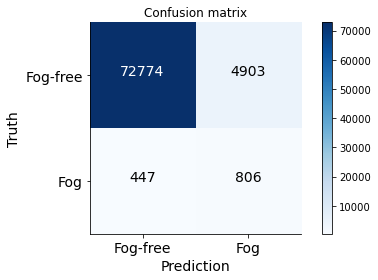

F1:0.232, POD:0.643, FAR:0.859, ETS:0.118, HSS:0.21


In [66]:
thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## alpha=0.5, gamma=2

In [68]:
fl_alpha = 0.5
fl_gamma = 2

lgb_file_6 = os.path.join(RESULT_DIR, 'model', 'lgb_use_var_from_TDCA_focal_loss_05_2.txt')
pre_result_file_6 = os.path.join(RESULT_DIR, 'test_result_use_var_from_TDCA_focal_loss_05_2.csv')
pre_metric_file_6 = os.path.join(RESULT_DIR, 'metrics_use_var_from_TDCA_focal_loss_05_2.csv')

### Train

In [69]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 8,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, fl_obj = create_lgb(X_train, y_train, 
                           X_val, y_val, 
                           features = features_3, 
                           model_params = model_params,
                           use_focal_loss = True,
                           fl_alpha = fl_alpha, 
                           fl_gamma = fl_gamma)

print(f'\nSaving model to {lgb_file_6}')
model.save_model(lgb_file_6)


Strating train...

Use focal loss (alpha=0.5, gamma=2)....

Load pretrained model from False
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.0107371
[600]	valid_0's focal_loss: 0.008561
[900]	valid_0's focal_loss: 0.00845801
Early stopping, best iteration is:
[892]	valid_0's focal_loss: 0.00845761
Train Finished

Saving model to ./forecast_results/model/lgb_use_var_from_TDCA_focal_loss_05_2.txt


### Test

In [70]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

print(f'Loading model from {lgb_file_6}\n')
clf = lgb.Booster(model_file = lgb_file_6)

# predict probabilities
pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = (pre_probs + (-np.min(pre_probs))) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df['pred_probs'] = pre_result_df['pred_probs'] + (-np.min(pre_probs))
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_6}')
pre_result_df.to_csv(pre_result_file_6)

Loading model from ./forecast_results/model/lgb_use_var_from_TDCA_focal_loss_05_2.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_use_var_from_TDCA_focal_loss_05_2.csv


Loading results from ./forecast_results/test_result_use_var_from_TDCA_focal_loss_05_2.csv

PR AUC=0.196


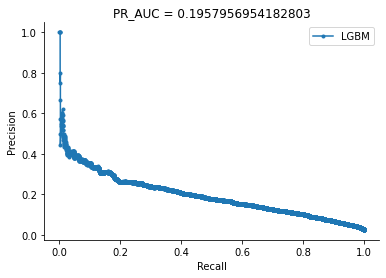

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


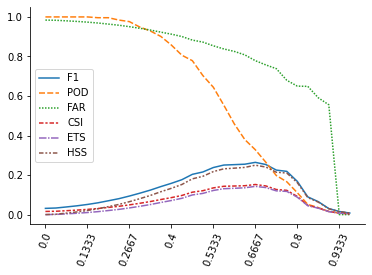


----------------------Max ETS------------------------
       thres        F1       POD       FAR       CSI       ETS       HSS
20  0.666667  0.264331  0.328063  0.778667  0.152294  0.142841  0.249975


In [71]:
print(f'Loading results from {pre_result_file_6}\n')
pre_result_df = pd.read_csv(pre_result_file_6, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

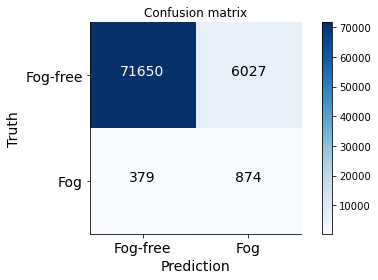

F1:0.214, POD:0.698, FAR:0.873, ETS:0.107, HSS:0.19


In [72]:
thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## alpha=0.5, gamma=4

In [73]:
fl_alpha = 0.5
fl_gamma = 4

lgb_file_7 = os.path.join(RESULT_DIR, 'model', 'lgb_use_var_from_TDCA_focal_loss_05_4.txt')
pre_result_file_7 = os.path.join(RESULT_DIR, 'test_result_use_var_from_TDCA_focal_loss_05_4.csv')
pre_metric_file_7 = os.path.join(RESULT_DIR, 'metrics_use_var_from_TDCA_focal_loss_05_4.csv')

### Train

In [74]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 8,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, fl_obj = create_lgb(X_train, y_train, 
                           X_val, y_val, 
                           features = features_3, 
                           model_params = model_params,
                           use_focal_loss = True,
                           fl_alpha = fl_alpha, 
                           fl_gamma = fl_gamma)

print(f'\nSaving model to {lgb_file_7}')
model.save_model(lgb_file_7)


Strating train...

Use focal loss (alpha=0.5, gamma=4)....

Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.00293259
[600]	valid_0's focal_loss: 0.00240899
[900]	valid_0's focal_loss: 0.00242233
Early stopping, best iteration is:
[664]	valid_0's focal_loss: 0.00239992
Train Finished

Saving model to ./forecast_results/model/lgb_use_var_from_TDCA_focal_loss_05_4.txt


### Test

In [75]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

print(f'Loading model from {lgb_file_7}\n')
clf = lgb.Booster(model_file = lgb_file_7)

# predict probabilities
pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = (pre_probs + (-np.min(pre_probs))) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df['pred_probs'] = pre_result_df['pred_probs'] + (-np.min(pre_probs))
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_7}')
pre_result_df.to_csv(pre_result_file_7)

Loading model from ./forecast_results/model/lgb_use_var_from_TDCA_focal_loss_05_4.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_use_var_from_TDCA_focal_loss_05_4.csv


Loading results from ./forecast_results/test_result_use_var_from_TDCA_focal_loss_05_4.csv

PR AUC=0.193


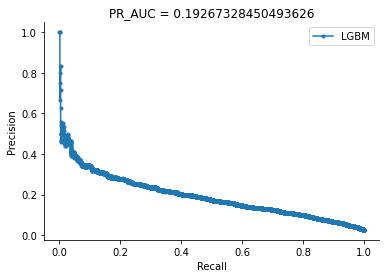

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


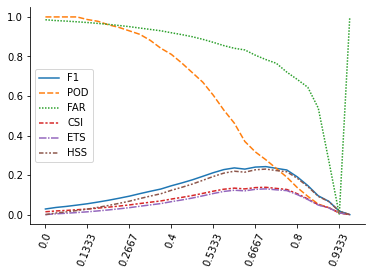


----------------------Max ETS------------------------
    thres        F1       POD       FAR       CSI       ETS       HSS
21    0.7  0.242775  0.277533  0.784247  0.138158  0.130148  0.230321


In [76]:
print(f'Loading results from {pre_result_file_7}\n')
pre_result_df = pd.read_csv(pre_result_file_7, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

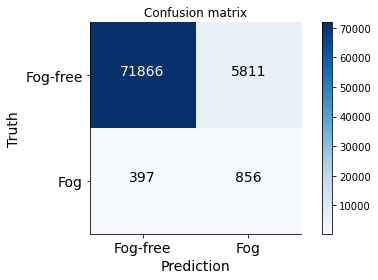

F1:0.216, POD:0.683, FAR:0.872, ETS:0.108, HSS:0.19


In [77]:
thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## Compare

| Loss  | F1  |  POD |  FAR | ETS | HSS |
|---|---|---|---|---| ---|
| CE | 0.199 | 0.144 | 0.678 | 0.106 | 0.19 |
| FL$\alpha$=0.2, $\gamma$=2 | 0.238 | 0.619 | 0.853 | 0.122 | 0.22 |
| FL$\alpha$=0.2, $\gamma$=4 | 0.232 | 0.643 | 0.859 | 0.118 | 0.21 |
| FL$\alpha$=0.5, $\gamma$=2 | 0.214 | 0.698 | 0.873 | 0.107 | 0.19 |
| FL$\alpha$=0.5, $\gamma$=4 | 0.216 | 0.683 | 0.872 | 0.108 | 0.19 |


# EasyEnsemble

## with focal loss (alpha=0.2, beta = 2)

In [69]:
n_estimators = 10
resample_type = 'None'
sampling_ratio = 0

alpha = 0.2
beta  = 4

model_save_path_prefix = f'easyensemble_{resample_type}_model_fl_02_4'
pre_result_file_8      = os.path.join(RESULT_DIR, 'test_result_easyensemble_02_4.csv')

### Train

In [70]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 6,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

models_files, focal_loss_obj = easyensemble(X_train, y_train, 
                                            X_val, y_val, 
                                            features = features_3, 
                                            target = CLS_LABEL, 
                                            model_params = model_params,
                                            n_estimators = n_estimators, 
                                            resample_type = resample_type, 
                                            sampling_ratio = sampling_ratio,
                                            result_dir     = RESULT_DIR,
                                            model_save_path_prefix = model_save_path_prefix,
                                            use_focal_loss = True, 
                                            alpha = alpha,
                                            beta  = beta)

Starting easyensemble...
Using focal loss...


== estimator: 0 ==

Strating train...

Use focal loss (alpha=0.2, gamma=4)....

Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.00250281
[600]	valid_0's focal_loss: 0.00157573
[900]	valid_0's focal_loss: 0.0015204
[1200]	valid_0's focal_loss: 0.00152277
Early stopping, best iteration is:
[1025]	valid_0's focal_loss: 0.00151834
Train Finished

Saving model to ./forecast_results/model/easyensemble_None_model_fl_02_4_0.txt


== estimator: 1 ==

Strating train...

Use focal loss (alpha=0.2, gamma=4)....

Load pretrained model from False
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.00250281
[600]	valid_0's focal_loss: 0.00157573
[900]	valid_0's focal_loss: 0.0015204
[1200]	valid_0's focal_loss: 0.00152277

### Test

In [71]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

preds_proba = np.zeros(len(y_test))

for n in range(n_estimators):
        
    print('======== Loading model =========')
    model_file = os.path.join(RESULT_DIR, 'model', f'{model_save_path_prefix}_{n}.txt')
    print(model_file)
    clf = lgb.Booster(model_file = model_file)
    
    print('=========== Predicting ==========')
    preds = special.expit(clf.predict(X_test, num_iteration=clf.best_iteration))
    print('prediction probability:\nmin=', round(np.min(preds),3), '\nmax=', round(np.max(preds),3), '\n\n')
    
    preds_proba += preds
    
preds_proba_mean = preds_proba / n_estimators
preds_proba_mean = (preds_proba_mean + (-np.min(preds_proba_mean))) / (np.max(preds_proba_mean) - np.min(preds_proba_mean))

pre_result_df = {
    'pred_probs': preds_proba_mean,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'Saving results to {pre_result_file_8}')
pre_result_df.to_csv(pre_result_file_8)


======== Loading model =========
./forecast_results/model/easyensemble_None_model_fl_02_4_0.txt
=========== Predicting ==========
prediction probability:
min= 0.074 
max= 0.561 


======== Loading model =========
./forecast_results/model/easyensemble_None_model_fl_02_4_1.txt
=========== Predicting ==========
prediction probability:
min= 0.074 
max= 0.561 


======== Loading model =========
./forecast_results/model/easyensemble_None_model_fl_02_4_2.txt
=========== Predicting ==========
prediction probability:
min= 0.074 
max= 0.561 


======== Loading model =========
./forecast_results/model/easyensemble_None_model_fl_02_4_3.txt
=========== Predicting ==========
prediction probability:
min= 0.074 
max= 0.561 


======== Loading model =========
./forecast_results/model/easyensemble_None_model_fl_02_4_4.txt
=========== Predicting ==========
prediction probability:
min= 0.074 
max= 0.561 


======== Loading model =========
./forecast_results/model/easyensemble_None_model_fl_02_4_5.txt
====

Loading results from ./forecast_results/test_result_easyensemble_02_4.csv

PR AUC=0.197


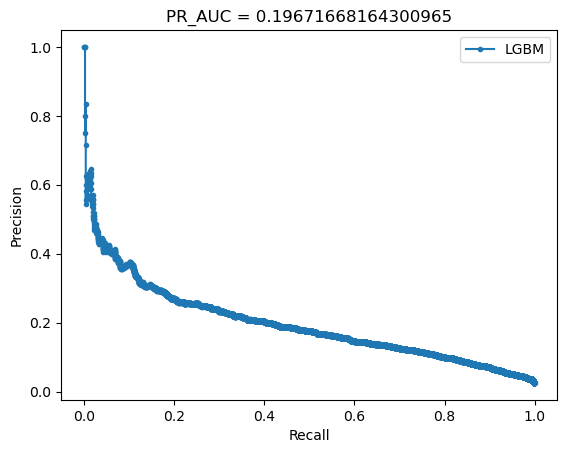

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


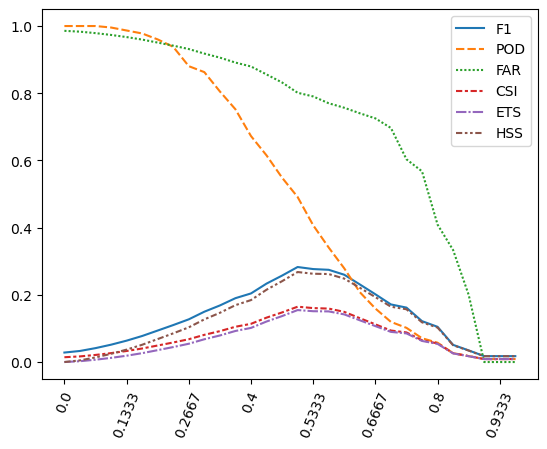


----------------------Max ETS------------------------
    thres        F1      POD       FAR       CSI       ETS       HSS
15    0.5  0.282803  0.49115  0.801431  0.164688  0.154651  0.267875


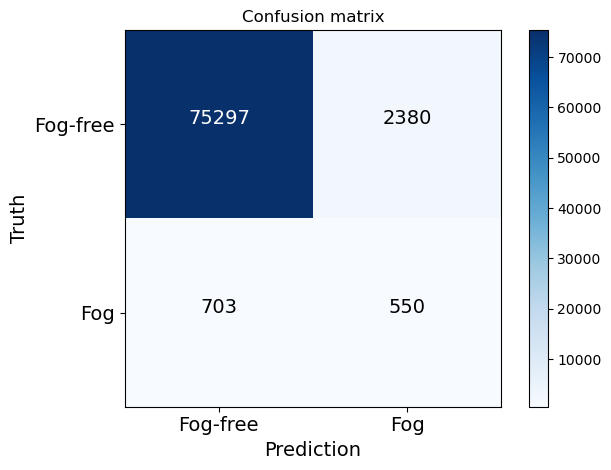

F1:0.263, POD:0.439, FAR:0.812, ETS:0.14, HSS:0.25


In [72]:
print(f'Loading results from {pre_result_file_8}\n')
pre_result_df = pd.read_csv(pre_result_file_8, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## EasyEnsemble with focal loss ($\alpha$=0.2, $\beta$=4) and undersample(sample_ratio=0.1)

In [65]:
n_estimators = 10
resample_type = 'under_sample'
sampling_ratio = 0.1

alpha=0.2
beta=4

model_save_path_prefix = f'easyensemble_{resample_type}_model_fl_02_4'
pre_result_file_9 = os.path.join(RESULT_DIR, f'test_result_easyensemble_{resample_type}_fl_02_4.csv')

### Train

In [66]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

models_files, focal_loss_obj = easyensemble(X_train, y_train, 
                                            X_val, y_val, 
                                            features = features_3, 
                                            target = CLS_LABEL, 
                                            model_params = model_params,
                                            n_estimators = n_estimators, 
                                            resample_type = resample_type, 
                                            sampling_ratio = sampling_ratio,
                                            result_dir     = RESULT_DIR,
                                            model_save_path_prefix = model_save_path_prefix,
                                            use_focal_loss = True, 
                                            alpha=alpha,
                                            beta=beta)

Starting easyensemble...
Using focal loss...


== estimator: 0 ==

After under_sample(0.1):  [(0, 55700), (1, 5570)]

Strating train...

Use focal loss (alpha=0.2, gamma=4)....

Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.00354541
[600]	valid_0's focal_loss: 0.00235003
[900]	valid_0's focal_loss: 0.00220489
[1200]	valid_0's focal_loss: 0.0021667
[1500]	valid_0's focal_loss: 0.00215878
Early stopping, best iteration is:
[1415]	valid_0's focal_loss: 0.00215642
Train Finished

Saving model to ./forecast_results/model/easyensemble_under_sample_model_fl_02_4_0.txt


== estimator: 1 ==

After under_sample(0.1):  [(0, 55700), (1, 5570)]

Strating train...

Use focal loss (alpha=0.2, gamma=4)....

Load pretrained model from False
Training until validation scores don't improve for 300 rounds
[300]

### Test

In [67]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

preds_proba = np.zeros(len(y_test))

for n in range(n_estimators):
        
    print('======== Loading model =========')
    model_file = os.path.join(RESULT_DIR, 'model', f'{model_save_path_prefix}_{n}.txt')
    print(model_file)
    clf = lgb.Booster(model_file = model_file)
    
    print('=========== Predicting ==========')
    preds = special.expit(clf.predict(X_test, num_iteration=clf.best_iteration))
    print('prediction probability:\nmin=', round(np.min(preds),3), '\nmax=', round(np.max(preds),3), '\n\n')
    
    preds_proba += preds
    
preds_proba_mean = preds_proba / n_estimators
preds_proba_mean = (preds_proba_mean + (-np.min(preds_proba_mean))) / (np.max(preds_proba_mean) - np.min(preds_proba_mean))

pre_result_df = {
    'pred_probs': preds_proba_mean,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'Saving results to {pre_result_file_9}')
pre_result_df.to_csv(pre_result_file_9)


======== Loading model =========
./forecast_results/model/easyensemble_under_sample_model_fl_02_4_0.txt
=========== Predicting ==========
prediction probability:
min= 0.06 
max= 0.703 


======== Loading model =========
./forecast_results/model/easyensemble_under_sample_model_fl_02_4_1.txt
=========== Predicting ==========
prediction probability:
min= 0.062 
max= 0.653 


======== Loading model =========
./forecast_results/model/easyensemble_under_sample_model_fl_02_4_2.txt
=========== Predicting ==========
prediction probability:
min= 0.056 
max= 0.697 


======== Loading model =========
./forecast_results/model/easyensemble_under_sample_model_fl_02_4_3.txt
=========== Predicting ==========
prediction probability:
min= 0.058 
max= 0.664 


======== Loading model =========
./forecast_results/model/easyensemble_under_sample_model_fl_02_4_4.txt
=========== Predicting ==========
prediction probability:
min= 0.057 
max= 0.712 


======== Loading model =========
./forecast_results/model/eas

Loading results from ./forecast_results/test_result_easyensemble_under_sample_fl_02_4.csv

PR AUC=0.202


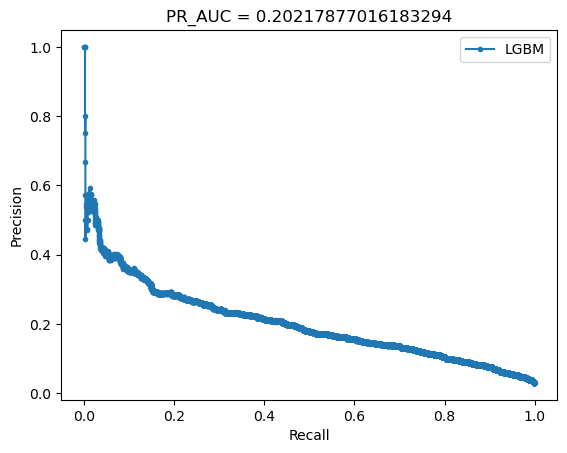

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


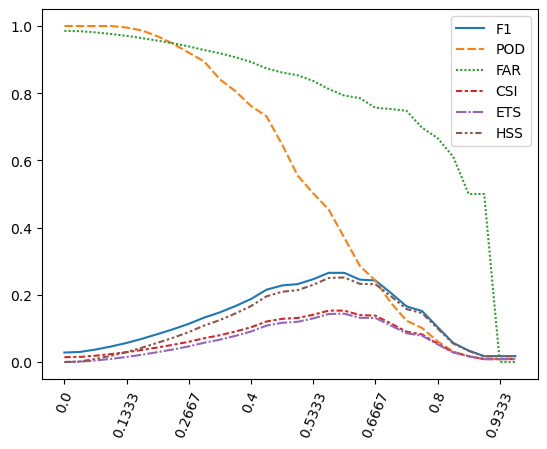


----------------------Max ETS------------------------
    thres        F1       POD       FAR       CSI       ETS       HSS
18    0.6  0.265403  0.370044  0.793103  0.153005  0.143901  0.251598


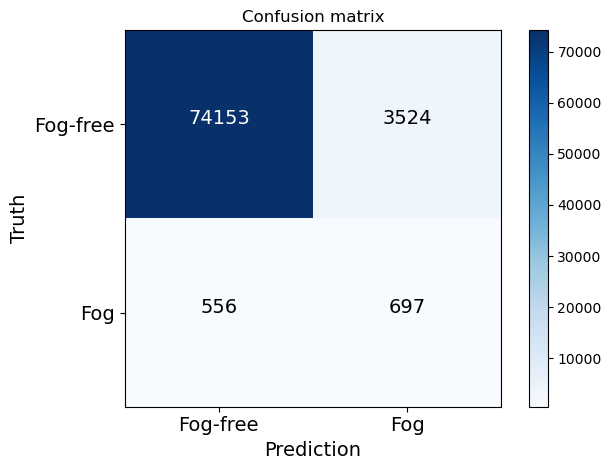

F1:0.255, POD:0.556, FAR:0.835, ETS:0.134, HSS:0.24


In [68]:
print(f'Loading results from {pre_result_file_9}\n')
pre_result_df = pd.read_csv(pre_result_file_9, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## EasyEnsemble with focal loss ($\alpha$=0.2, $\beta$=4) and oversample(sample_ratio=0.1)

In [73]:
n_estimators = 10
resample_type = 'over_sample'
sampling_ratio = 0.1

alpha=0.2
beta=4

model_save_path_prefix = f'easyensemble_{resample_type}_model_fl_02_4'
pre_result_file_10 = os.path.join(RESULT_DIR, f'test_result_easyensemble_{resample_type}_fl_02_4.csv')

### Train

In [74]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

models_files, focal_loss_obj = easyensemble(X_train, y_train, 
                                            X_val, y_val, 
                                            features = features_3, 
                                            target = CLS_LABEL, 
                                            model_params = model_params,
                                            n_estimators = n_estimators, 
                                            resample_type = resample_type, 
                                            sampling_ratio = sampling_ratio,
                                            result_dir     = RESULT_DIR,
                                            model_save_path_prefix = model_save_path_prefix,
                                            use_focal_loss = True, 
                                            alpha=alpha,
                                            beta=beta)

Starting easyensemble...
Using focal loss...


== estimator: 0 ==

After over_sample(0.1):  [(0, 315273), (1, 31527)]

Strating train...

Use focal loss (alpha=0.2, gamma=4)....

Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.00347268
[600]	valid_0's focal_loss: 0.00226869
[900]	valid_0's focal_loss: 0.00207483
[1200]	valid_0's focal_loss: 0.00197708
[1500]	valid_0's focal_loss: 0.00190867
[1800]	valid_0's focal_loss: 0.00186448
[2100]	valid_0's focal_loss: 0.00183251
[2400]	valid_0's focal_loss: 0.00181158
[2700]	valid_0's focal_loss: 0.00179962
[3000]	valid_0's focal_loss: 0.00179541
Early stopping, best iteration is:
[2955]	valid_0's focal_loss: 0.00179449
Train Finished

Saving model to ./forecast_results/model/easyensemble_over_sample_model_fl_02_4_0.txt


== estimator: 1 ==

After over

[1800]	valid_0's focal_loss: 0.0018672
[2100]	valid_0's focal_loss: 0.00183604
[2400]	valid_0's focal_loss: 0.00181446
[2700]	valid_0's focal_loss: 0.00180012
[3000]	valid_0's focal_loss: 0.00179229
[3300]	valid_0's focal_loss: 0.00179064
[3600]	valid_0's focal_loss: 0.00179711
Early stopping, best iteration is:
[3318]	valid_0's focal_loss: 0.0017904
Train Finished

Saving model to ./forecast_results/model/easyensemble_over_sample_model_fl_02_4_9.txt


### Test

In [75]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

preds_proba = np.zeros(len(y_test))

for n in range(n_estimators):
        
    print('======== Loading model =========')
    model_file = os.path.join(RESULT_DIR, 'model', f'{model_save_path_prefix}_{n}.txt')
    print(model_file)
    clf = lgb.Booster(model_file = model_file)
    
    print('=========== Predicting ==========')
    preds = special.expit(clf.predict(X_test, num_iteration=clf.best_iteration))
    print('prediction probability:\nmin=', round(np.min(preds),3), '\nmax=', round(np.max(preds),3), '\n\n')
    
    preds_proba += preds
    
preds_proba_mean = preds_proba / n_estimators
preds_proba_mean = (preds_proba_mean + (-np.min(preds_proba_mean))) / (np.max(preds_proba_mean) - np.min(preds_proba_mean))

pre_result_df = {
    'pred_probs': preds_proba_mean,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'Saving results to {pre_result_file_10}')
pre_result_df.to_csv(pre_result_file_10)


======== Loading model =========
./forecast_results/model/easyensemble_over_sample_model_fl_02_4_0.txt
=========== Predicting ==========
prediction probability:
min= 0.021 
max= 0.653 


======== Loading model =========
./forecast_results/model/easyensemble_over_sample_model_fl_02_4_1.txt
=========== Predicting ==========
prediction probability:
min= 0.016 
max= 0.648 


======== Loading model =========
./forecast_results/model/easyensemble_over_sample_model_fl_02_4_2.txt
=========== Predicting ==========
prediction probability:
min= 0.018 
max= 0.653 


======== Loading model =========
./forecast_results/model/easyensemble_over_sample_model_fl_02_4_3.txt
=========== Predicting ==========
prediction probability:
min= 0.016 
max= 0.666 


======== Loading model =========
./forecast_results/model/easyensemble_over_sample_model_fl_02_4_4.txt
=========== Predicting ==========
prediction probability:
min= 0.017 
max= 0.665 


======== Loading model =========
./forecast_results/model/easyens

Loading results from ./forecast_results/test_result_easyensemble_over_sample_fl_02_4.csv

PR AUC=0.193


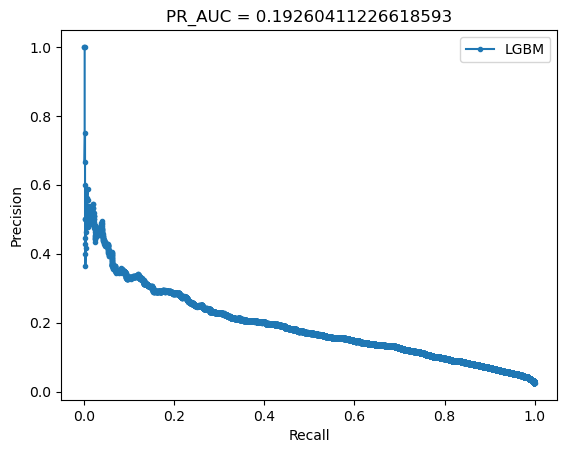

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


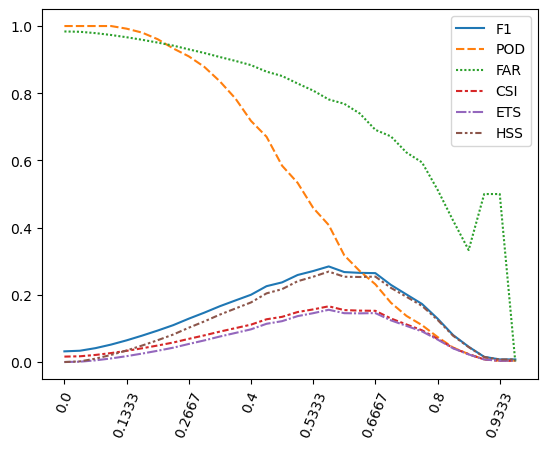


----------------------Max ETS------------------------
       thres        F1       POD       FAR       CSI       ETS       HSS
17  0.566667  0.284542  0.407843  0.781513  0.165869  0.155513  0.269167


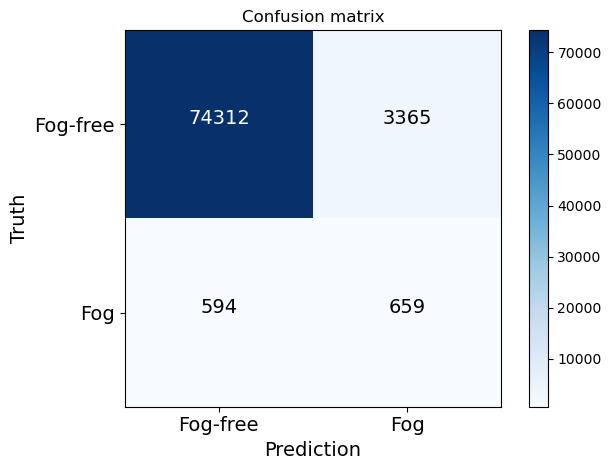

F1:0.25, POD:0.526, FAR:0.836, ETS:0.131, HSS:0.23


In [76]:
print(f'Loading results from {pre_result_file_10}\n')
pre_result_df = pd.read_csv(pre_result_file_10, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## focal loss ($\alpha$=0.2, $\beta$=4) and undersample(sample_ratio=0.1)

In [56]:
lgb_file_11        = os.path.join(RESULT_DIR, 'model', 'lgb_under_sample_without_easyensemble.txt')
pre_result_file_11 = os.path.join(RESULT_DIR, 'test_result_under_sample_without_easyensemble.csv')
pre_metric_file_11 = os.path.join(RESULT_DIR, 'metrics_under_sample_without_easyensemble.csv')

alpha=0.2
beta=4

In [57]:
X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

rs = RandomUnderSampler(sampling_strategy=0.1, random_state=44)
print(f'After undersample: ', sorted(Counter(y_train).items()))

X_train_rus, y_train_rus = rs.fit_resample(X_train, y_train)
print(f'After undersample: ', sorted(Counter(y_train_rus).items()))

After undersample:  [(0, 315273), (1, 5570)]
After undersample:  [(0, 55700), (1, 5570)]


### Train

In [58]:
X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 8,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, focal_loss = create_lgb(X_train_rus, y_train_rus,
                               X_val, y_val, 
                               features = features_3, 
                               model_params = model_params, 
                               use_focal_loss = True,
                               fl_alpha=alpha, 
                               fl_gamma=beta)

print(f'\nSaving model to {lgb_file_11}')
model.save_model(lgb_file_11)


Strating train...

Use focal loss (alpha=0.2, gamma=4)....

Load pretrained model from False
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.0035067
[600]	valid_0's focal_loss: 0.00230296
[900]	valid_0's focal_loss: 0.00216703
[1200]	valid_0's focal_loss: 0.00212553
[1500]	valid_0's focal_loss: 0.00212192
Early stopping, best iteration is:
[1374]	valid_0's focal_loss: 0.00211721
Train Finished

Saving model to ./forecast_results/model/lgb_under_sample_without_easyensemble.txt


### Test

In [59]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

print(f'Loading model from {lgb_file_11}\n')
clf = lgb.Booster(model_file = lgb_file_11)

# predict probabilities
# pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = special.expit(clf.predict(X_test, num_iteration=clf.best_iteration))
pre_probs = (pre_probs + (-np.min(pre_probs))) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df['pred_probs'] = pre_result_df['pred_probs'] + (-np.min(pre_probs))
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_11}')
pre_result_df.to_csv(pre_result_file_11)

Loading model from ./forecast_results/model/lgb_under_sample_without_easyensemble.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_under_sample_without_easyensemble.csv


Loading results from ./forecast_results/test_result_under_sample_without_easyensemble.csv

PR AUC=0.206


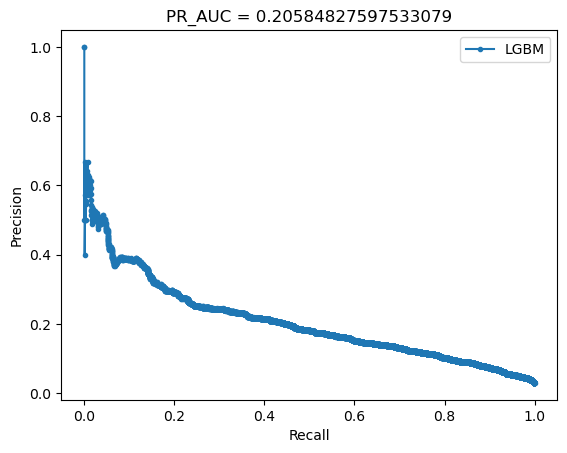

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


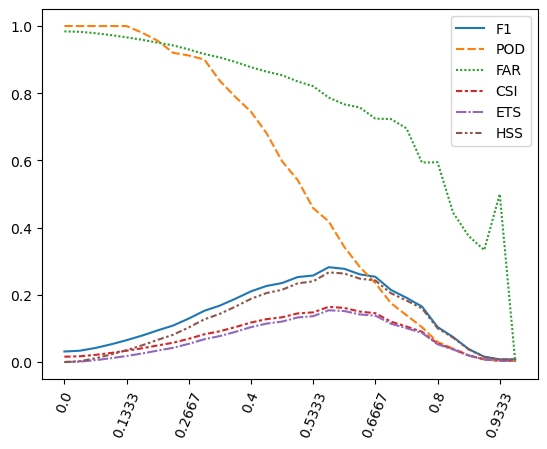


----------------------Max ETS------------------------
       thres        F1       POD       FAR       CSI      ETS       HSS
17  0.566667  0.282258  0.418327  0.787018  0.164319  0.15394  0.266808


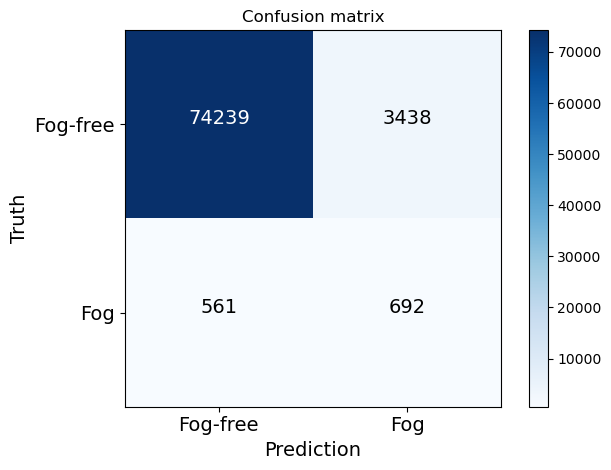

F1:0.257, POD:0.552, FAR:0.832, ETS:0.135, HSS:0.24


In [60]:
print(f'Loading results from {pre_result_file_11}\n')
pre_result_df = pd.read_csv(pre_result_file_11, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')

## focal loss ($\alpha$=0.2, $\beta$=4) and oversample(sample_ratio=0.1)

In [61]:
lgb_file_12        = os.path.join(RESULT_DIR, 'model', 'lgb_over_sample_without_easyensemble.txt')
pre_result_file_12 = os.path.join(RESULT_DIR, 'test_result_over_sample_without_easyensemble.csv')
pre_metric_file_12 = os.path.join(RESULT_DIR, 'metrics_over_sample_without_easyensemble.csv')

alpha=0.2
beta=4

X_train = train_dataset[features_3]
y_train = train_dataset[CLS_LABEL]

ros = RandomOverSampler(sampling_strategy=0.1, random_state=44)
print(f'Before over-sample: ', sorted(Counter(y_train).items()))

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print(f'After over-sample: ', sorted(Counter(y_train_ros).items()))

Before over-sample:  [(0, 315273), (1, 5570)]
After over-sample:  [(0, 315273), (1, 31527)]


### Train

In [62]:
X_val = valid_dataset[features_3]
y_val = valid_dataset[CLS_LABEL]

X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

model_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': 8,
        'num_leaves': 48,
        'num_thread': 16,
        'bagging_seed': 100,
        # 'feature_fraction': 0.8,
        # 'feature_fraction_seed': 66,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_fraction_seed': 66,
        'verbose':-1,
}

model, focal_loss = create_lgb(X_train_ros, y_train_ros,
                               X_val, y_val, 
                               features = features_3, 
                               model_params = model_params, 
                               use_focal_loss = True,
                               fl_alpha=alpha, 
                               fl_gamma=beta)

print(f'\nSaving model to {lgb_file_12}')
model.save_model(lgb_file_12)


Strating train...

Use focal loss (alpha=0.2, gamma=4)....

Load pretrained model from False
[LightGBM] [Warning] bagging_seed is set=100, bagging_fraction_seed=66 will be ignored. Current value: bagging_seed=100
Training until validation scores don't improve for 300 rounds
[300]	valid_0's focal_loss: 0.0034318
[600]	valid_0's focal_loss: 0.00219347
[900]	valid_0's focal_loss: 0.00200645
[1200]	valid_0's focal_loss: 0.00192153
[1500]	valid_0's focal_loss: 0.00186899
[1800]	valid_0's focal_loss: 0.00183386
[2100]	valid_0's focal_loss: 0.00180829
[2400]	valid_0's focal_loss: 0.00179781
[2700]	valid_0's focal_loss: 0.00179422
Early stopping, best iteration is:
[2647]	valid_0's focal_loss: 0.00179369
Train Finished

Saving model to ./forecast_results/model/lgb_over_sample_without_easyensemble.txt


### Test

In [63]:
X_test = test_dataset[features_3]
y_test = test_dataset[CLS_LABEL]

print(f'Loading model from {lgb_file_12}\n')
clf = lgb.Booster(model_file = lgb_file_12)

# predict probabilities
# pre_probs = clf.predict(X_test, num_iteration=clf.best_iteration)
pre_probs = special.expit(clf.predict(X_test, num_iteration=clf.best_iteration))
pre_probs = (pre_probs + (-np.min(pre_probs))) / (np.max(pre_probs) - np.min(pre_probs))
print('prediction probability:\nmin =', round(np.min(pre_probs), 3),'\nmax =', round(np.max(pre_probs),3))

pre_result_df = {
    'pred_probs': pre_probs,
    'gt': y_test,
}
pre_result_df = pd.DataFrame(pre_result_df)
pre_result_df['pred_probs'] = pre_result_df['pred_probs'] + (-np.min(pre_probs))
pre_result_df[INFO_COLS] = test_dataset[INFO_COLS]

pre_result_df['fsl_vis_cls'] = np.where(pre_result_df['fsl_vis (t6)']<=1, 1, 0)
pre_result_df['wrf_vis_cls'] = np.where(pre_result_df['VIS_GDS3_SFC (t6)']/1000<=1, 1, 0)

print(f'\nSaving results to {pre_result_file_12}')
pre_result_df.to_csv(pre_result_file_12)

Loading model from ./forecast_results/model/lgb_over_sample_without_easyensemble.txt

prediction probability:
min = 0.0 
max = 1.0

Saving results to ./forecast_results/test_result_over_sample_without_easyensemble.csv


Loading results from ./forecast_results/test_result_over_sample_without_easyensemble.csv

PR AUC=0.192


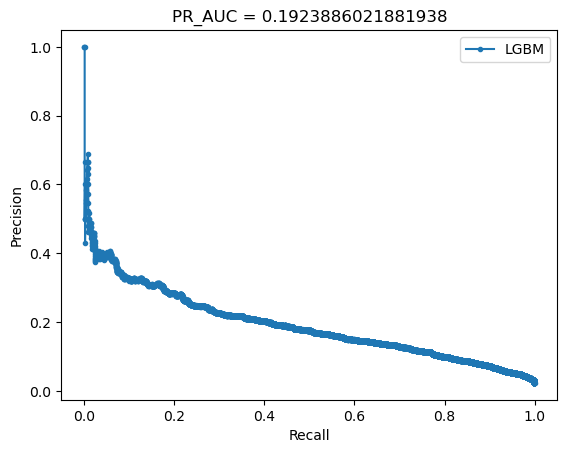

Finding the optimal threshold from subset of results.....
thres_list: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667]


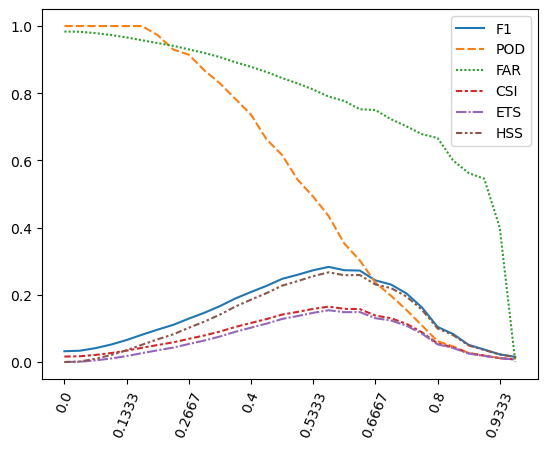


----------------------Max ETS------------------------
       thres        F1       POD       FAR       CSI       ETS       HSS
17  0.566667  0.283186  0.434109  0.789869  0.164948  0.154096  0.267042


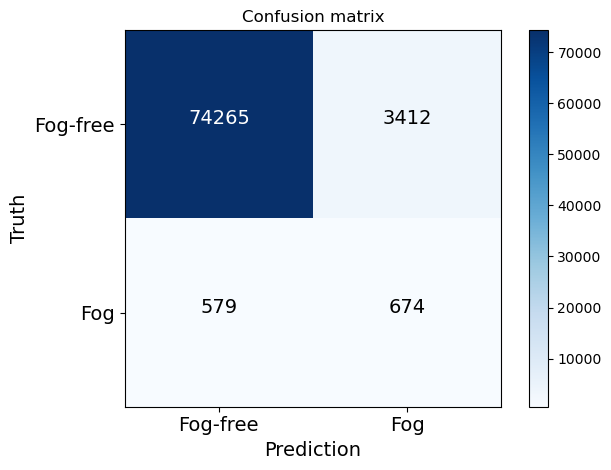

F1:0.252, POD:0.538, FAR:0.835, ETS:0.132, HSS:0.23


In [64]:
print(f'Loading results from {pre_result_file_12}\n')
pre_result_df = pd.read_csv(pre_result_file_12, index_col=0)

# PR Curve
precision, recall, pr_thres = precision_recall_curve(pre_result_df['gt'].values, 
                                                     pre_result_df['pred_probs'].values)
PR_auc = auc(recall, precision)
print('PR AUC=%.3f' % (PR_auc))

show_PR_curves(recall, precision, PR_auc)

print('Finding the optimal threshold from subset of results.....')
opt_thres = find_opt_thres(pr_thres, pre_result_df.sample(frac=0.2))

thres = 0.5
pre_cls = np.where(pre_result_df['pred_probs'] >= thres, 1, 0)
        
f1, pod, far, csi, ets, hss, acc = show_confusion_matrix_and_cls_metrics(pre_cls, pre_result_df['gt'], show_img=True)
print(f'F1:{round(f1,3)}, POD:{round(pod,3)}, FAR:{round(far,3)}, ETS:{round(ets,3)}, HSS:{round(hss,2)}')



## Compare

| Method  | F1  |  POD |  FAR | ETS | HSS |
|---|---|---|---|---| ---|
|  focal loss ($\alpha$=0.2, $\beta$=4)  |  0.232 | 0.643 | 0.859 | 0.118 | 0.21 |
|  EasyEnsemble with focal loss ($\alpha$=0.2, $\beta$=4)  |  0.263  | 0.439  | 0.812  | 0.14  |  0.25 |
|  EasyEnsemble with focal loss ($\alpha$=0.2, $\beta$=4) and undersample(sample_ratio=0.1)   | 0.255  |  0.556 | 0.825  | 0.134  |  0.24 |
|  EasyEnsemble with focal loss ($\alpha$=0.2, $\beta$=4) and oversample(sample_ratio=0.1)  |  0.25 | 0.526  |  0.836 | 0.131  | 0.23  |
|  focal loss ($\alpha$=0.2, $\beta$=4) and undersample(sample_ratio=0.1)  |  0.257 | 0.552  |  0.832 | 0.135  | 0.24  |
|  focal loss ($\alpha$=0.2, $\beta$=4) and oversample(sample_ratio=0.1)  |  0.252 | 0.538  |  0.835 | 0.132  | 0.23  |


F1:0.25, POD:0.526, FAR:0.836, ETS:0.131, HSS:0.23
